In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# split data in 60%/20%/20% train/validation/test sets
valid_set_size_percentage = 20 
test_set_size_percentage = 20 

from pandas import read_csv

Using TensorFlow backend.


In [2]:
df = read_csv('dataset/prices-split-adjusted.csv', index_col = 0)

In [3]:
df[1000:1020]

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-05,MHK,48.259998,48.119999,47.419998,48.380001,621800.0
2010-01-05,MJN,45.040001,44.610001,44.150002,45.279999,5970900.0
2010-01-05,MKC,36.220001,36.200001,36.060001,36.320000,548700.0
2010-01-05,MLM,91.279999,90.430000,90.080002,91.830002,435000.0
2010-01-05,MMC,21.780001,21.340000,21.170000,21.910000,4433900.0
2010-01-05,MMM,82.800003,82.500000,81.699997,83.230003,2847000.0
2010-01-05,MNST,6.565000,6.571667,6.505000,6.586667,3784200.0
2010-01-05,MO,19.809999,19.799999,19.670000,19.850000,11742100.0
2010-01-05,MON,83.760002,85.269997,83.260002,85.610001,5616300.0


In [4]:
start = min(df.index.tolist())
end = max(df.index.tolist())
print("Start date: ", start, ", End date: ", end)

Start date:  2010-01-04 , End date:  2016-12-30


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
symbol    851264 non-null object
open      851264 non-null float64
close     851264 non-null float64
low       851264 non-null float64
high      851264 non-null float64
volume    851264 non-null float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


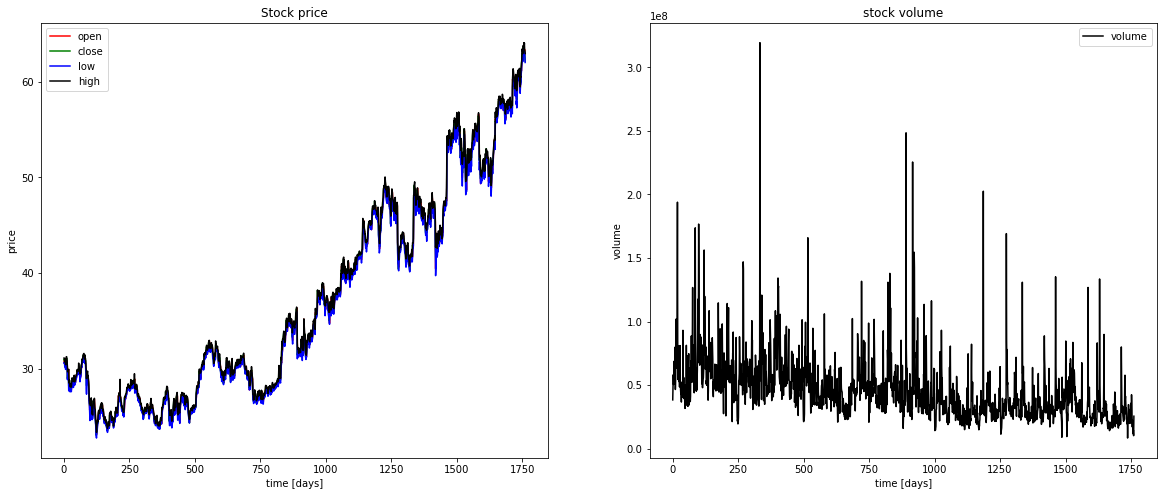

In [6]:
ticker = 'MSFT'
# Visualize data
plt.figure(figsize=(20, 8));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == ticker].open.values, color='red', label='open')
plt.plot(df[df.symbol == ticker].close.values, color='green', label='close')
plt.plot(df[df.symbol == ticker].low.values, color='blue', label='low')
plt.plot(df[df.symbol == ticker].high.values, color='black', label='high')
plt.title('Stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.symbol == ticker].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [7]:
#get all the value of MSFT
subset = df[df.symbol == ticker].loc[:,list(df.keys())[1:]]
subset.head()

,open,close,low,high,volume
date,,,,,
2010-01-04,30.620001,30.950001,30.590000,31.100000,38409100.0
2010-01-05,30.850000,30.959999,30.639999,31.100000,49749600.0
2010-01-06,30.879999,30.770000,30.520000,31.080000,58182400.0
2010-01-07,30.629999,30.450001,30.190001,30.700001,50559700.0
2010-01-08,30.280001,30.660000,30.240000,30.879999,51197400.0


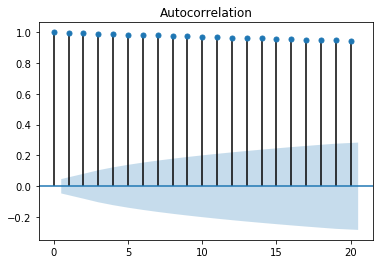

In [8]:
# Significant coorelation between lags 
acf = plot_acf(subset['open'], lags = 20)

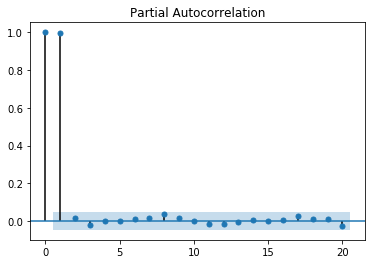

In [9]:
# No significant pattern in pacf
pacf = plot_pacf(subset['open'], lags = 20)

In [10]:
w = 20 # window size 

In [11]:
roll_df = subset.rolling(window=w).mean()
roll_df['symbol'] = df[df.symbol == ticker].loc[:,'symbol']
roll_df.dropna(inplace=True)
roll_df.describe()

,open,close,low,high,volume
count,1743.000000,1743.000000,1743.000000,1743.000000,1.743000e+03
mean,37.006116,37.025847,36.684453,37.331937,4.585257e+07
std,10.631166,10.646357,10.559463,10.717578,1.458467e+07
min,24.142500,24.113000,23.951500,24.319500,1.848679e+07
25%,27.713250,27.705250,27.512500,27.909500,3.384782e+07
50%,32.928000,33.012500,32.660500,33.224000,4.433952e+07
75%,45.644000,45.721250,45.265750,46.109750,5.600551e+07
max,62.203500,62.264000,61.821000,62.665500,8.761466e+07


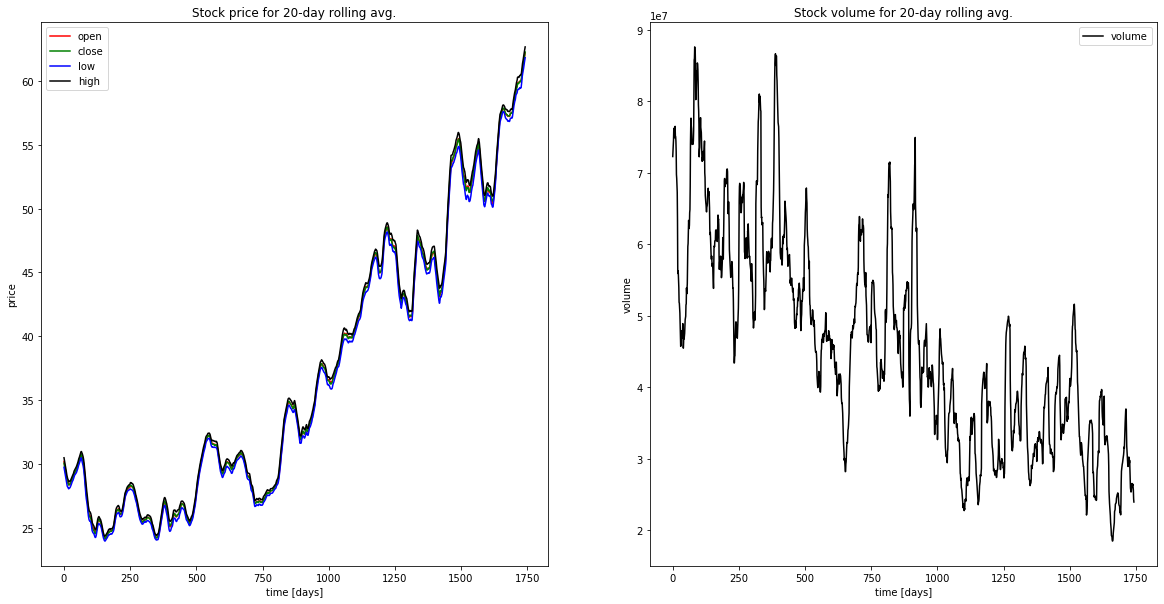

In [12]:
plt.figure(figsize=(20, 10));
plt.subplot(1,2,1);
plt.plot(roll_df[roll_df.symbol == ticker].open.values, color='red', label='open')
plt.plot(roll_df[roll_df.symbol == ticker].close.values, color='green', label='close')
plt.plot(roll_df[roll_df.symbol == ticker].low.values, color='blue', label='low')
plt.plot(roll_df[roll_df.symbol == ticker].high.values, color='black', label='high')
plt.title('Stock price for {}-day rolling avg.'.format(w))
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(roll_df[roll_df.symbol == ticker].volume.values, color='black', label='volume')
plt.title('Stock volume for {}-day rolling avg.'.format(w))
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [13]:
# function for min-max normalization of stock
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
def normalize_data(df):
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

In [14]:
# choose one stock
df_stock = df[df.symbol == ticker].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)
df_stock_norm.head()

df_stock.columns.values =  ['open', 'close', 'low', 'high']


,open,close,low,high
date,,,,
2010-01-04,0.184785,0.195518,0.193215,0.190780
2010-01-05,0.190429,0.195765,0.194444,0.190780
2010-01-06,0.191166,0.191086,0.191495,0.190289
2010-01-07,0.185031,0.183206,0.183383,0.180971
2010-01-08,0.176442,0.188377,0.184612,0.185385


In [15]:
len(df_stock)

1762

In [16]:
# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array shape (1762,4)
    #print(data_raw.shape)
    data = []
    cnt = 0
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    
    data = np.array(data);
   # print(data.shape)
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    print(y_train.shape)
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    print(x_valid.shape)
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


In [17]:
# create train, test data
seq_len = 19 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len+1)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

(1046, 4)
(348, 19, 4)
x_train.shape =  (1046, 19, 4)
y_train.shape =  (1046, 4)
x_valid.shape =  (348, 19, 4)
y_valid.shape =  (348, 4)
x_test.shape =  (348, 19, 4)
y_test.shape =  (348, 4)


C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
x_train

array([[[0.1847853 , 0.19551837, 0.19321534, 0.1907798 ],
        [0.19042945, 0.19576457, 0.19444442, 0.1907798 ],
        [0.19116562, 0.19108594, 0.19149459, 0.19028937],
        ...,
        [0.15361963, 0.16399902, 0.15462144, 0.15939187],
        [0.16564417, 0.15144054, 0.15142574, 0.16061798],
        [0.16711656, 0.12730855, 0.12118977, 0.16184405]],

       [[0.19042945, 0.19576457, 0.19444442, 0.1907798 ],
        [0.19116562, 0.19108594, 0.19149459, 0.19028937],
        [0.18503065, 0.18320614, 0.18338252, 0.1809711 ],
        ...,
        [0.16564417, 0.15144054, 0.15142574, 0.16061798],
        [0.16711656, 0.12730855, 0.12118977, 0.16184405],
        [0.13006133, 0.13297218, 0.12758112, 0.12653262]],

       [[0.19116562, 0.19108594, 0.19149459, 0.19028937],
        [0.18503065, 0.18320614, 0.18338252, 0.1809711 ],
        [0.17644174, 0.18837725, 0.1846116 , 0.18538498],
        ...,
        [0.16711656, 0.12730855, 0.12118977, 0.16184405],
        [0.13006133, 0.132972

In [19]:
# Choose only open prices
x_train, y_train, x_valid, y_valid, x_test, y_test = x_train[:,:,0], y_train[:,0], x_valid[:,:,0], y_valid[:,0], x_test[:,:,0], y_test[:,0]
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1046, 19)
y_train.shape =  (1046,)
x_valid.shape =  (348, 19)
y_valid.shape =  (348,)
x_test.shape =  (348, 19)
y_test.shape =  (348,)


In [20]:
x_train[0]

array([0.1847853 , 0.19042945, 0.19116562, 0.18503065, 0.17644174,
       0.18699384, 0.17325153, 0.17595092, 0.17717789, 0.19607362,
       0.18797546, 0.18944783, 0.1845399 , 0.16957055, 0.15092025,
       0.14993867, 0.15361963, 0.16564417, 0.16711656])

In [21]:
#Build the model
# Predict every 20th time step
model = Sequential()
model.add(LSTM(256,input_shape=(seq_len,1)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 280,705
Trainable params: 280,705
Non-trainable params: 0
_________________________________________________________________


In [23]:
x_train.shape

(1046, 19)

In [24]:
#Reshape data for (Sample,Timestep,Features) 
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_valid = x_valid.reshape((x_valid.shape[0],x_valid.shape[1],1))
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],1))

In [25]:
x_train.shape

(1046, 19, 1)

In [26]:
epoch_size = 2

In [27]:
#Fit model with history to check for overfitting
history = model.fit(x_train,y_train,epochs=epoch_size,validation_data=(x_valid,y_valid),shuffle=False)


Train on 1046 samples, validate on 348 samples
Epoch 1/2
1046/1046 [==============================] - 2s 2ms/step - loss: 0.0021 - accuracy: 9.5602e-04 - val_loss: 0.0063 - val_accuracy: 0.0000e+00
Epoch 2/2
1046/1046 [==============================] - 2s 1ms/step - loss: 0.0015 - accuracy: 9.5602e-04 - val_loss: 0.0011 - val_accuracy: 0.0000e+00


In [28]:
x_test.shape

(348, 19, 1)

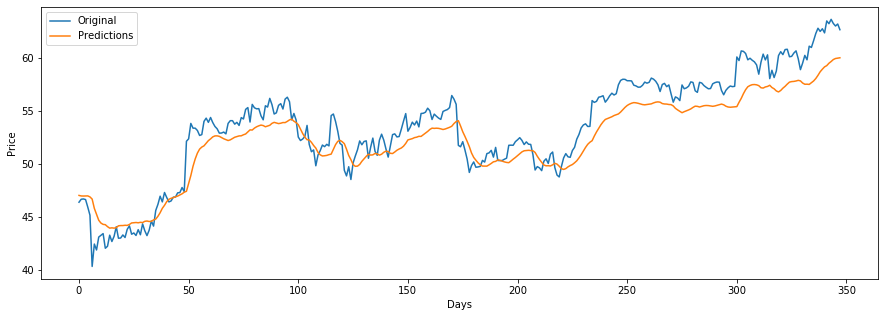

In [29]:
# Visualise predictions
Xt = model.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot( np.arange(y_test.shape[0]), min_max_scaler.inverse_transform(y_test.reshape(-1,1)),label='Original')
plt.plot(np.arange(y_test.shape[0]), min_max_scaler.inverse_transform(Xt), label ='Predictions')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

In [30]:
Xt

array([[0.5910077 ],
       [0.58974403],
       [0.5895773 ],
       [0.58977854],
       [0.5898875 ],
       [0.5875435 ],
       [0.5824787 ],
       [0.5608501 ],
       [0.5467332 ],
       [0.5333395 ],
       [0.52681845],
       [0.5237361 ],
       [0.5230363 ],
       [0.51853156],
       [0.5150051 ],
       [0.5157136 ],
       [0.51499975],
       [0.5160806 ],
       [0.5204431 ],
       [0.52099085],
       [0.52099735],
       [0.52165043],
       [0.521351  ],
       [0.52360547],
       [0.5270372 ],
       [0.52756155],
       [0.52808833],
       [0.52742577],
       [0.5284958 ],
       [0.52793396],
       [0.53080666],
       [0.5315472 ],
       [0.53041   ],
       [0.53075856],
       [0.53415215],
       [0.5359896 ],
       [0.5425361 ],
       [0.55082697],
       [0.5609884 ],
       [0.56807023],
       [0.57653403],
       [0.5819587 ],
       [0.58436394],
       [0.585832  ],
       [0.5878395 ],
       [0.5894898 ],
       [0.59219736],
       [0.594

In [31]:
y_test

array([0.5752147 , 0.58208591, 0.58282209, 0.58134967, 0.56392638,
       0.54503065, 0.42601229, 0.47803681, 0.46429443, 0.49423313,
       0.49840496, 0.50233131, 0.46822081, 0.47288346, 0.49865031,
       0.4839264 , 0.4959509 , 0.51828218, 0.49153372, 0.49202452,
       0.4991411 , 0.49325151, 0.51239266, 0.52024542, 0.5008589 ,
       0.50380366, 0.49791413, 0.51141104, 0.49963193, 0.52490798,
       0.5089571 , 0.49766869, 0.51018407, 0.53153374, 0.5197546 ,
       0.55607362, 0.5703068 , 0.5892024 , 0.57595094, 0.59779144,
       0.58625767, 0.57595094, 0.57815956, 0.58699382, 0.58723926,
       0.59705517, 0.59754599, 0.6093251 , 0.59975458, 0.71680979,
       0.72245396, 0.75828226, 0.74723929, 0.74723929, 0.74184049,
       0.7303067 , 0.73226994, 0.76294479, 0.7705522 , 0.7607362 ,
       0.77202452, 0.7602454 , 0.75116567, 0.74576687, 0.73570552,
       0.73595097, 0.73815946, 0.73398773, 0.75828226, 0.76466258,
       0.76466258, 0.75656437, 0.7607362 , 0.75361961, 0.77177

In [32]:
df = pd.read_csv("dataset/prices-split-adjusted.csv")
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df = df[df.symbol == 'MSFT']
df.drop(['symbol'],1,inplace=True)

# # Bug fixed at here, please update the denormalize function to this one
def denormalize(df, normalized_value): 
    df = df['open'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(df, Xt)
newy_test = denormalize(df, y_test)

In [33]:
newy_test

array([[46.529999],
       [46.810001],
       [46.84    ],
       [46.779999],
       [46.07    ],
       [45.299999],
       [40.450001],
       [42.57    ],
       [42.009998],
       [43.23    ],
       [43.400002],
       [43.560001],
       [42.169998],
       [42.360001],
       [43.41    ],
       [42.810001],
       [43.299999],
       [44.209999],
       [43.119999],
       [43.139999],
       [43.43    ],
       [43.189999],
       [43.970001],
       [44.290001],
       [43.5     ],
       [43.619999],
       [43.380001],
       [43.93    ],
       [43.450001],
       [44.48    ],
       [43.830002],
       [43.369999],
       [43.880001],
       [44.75    ],
       [44.27    ],
       [45.75    ],
       [46.330002],
       [47.099998],
       [46.560001],
       [47.450001],
       [46.98    ],
       [46.560001],
       [46.650002],
       [47.009998],
       [47.02    ],
       [47.419998],
       [47.439999],
       [47.919998],
       [47.529999],
       [52.299999],


In [34]:
newp

array([[47.17356 ],
       [47.12207 ],
       [47.115273],
       [47.123474],
       [47.127914],
       [47.032394],
       [46.826008],
       [45.94464 ],
       [45.369377],
       [44.82358 ],
       [44.557854],
       [44.432243],
       [44.40373 ],
       [44.220158],
       [44.076458],
       [44.105328],
       [44.076237],
       [44.12028 ],
       [44.298054],
       [44.320374],
       [44.32064 ],
       [44.34725 ],
       [44.33505 ],
       [44.42692 ],
       [44.566765],
       [44.58813 ],
       [44.609596],
       [44.5826  ],
       [44.6262  ],
       [44.603306],
       [44.720367],
       [44.750546],
       [44.70421 ],
       [44.71841 ],
       [44.856697],
       [44.931576],
       [45.198345],
       [45.536198],
       [45.950275],
       [46.23886 ],
       [46.58376 ],
       [46.804817],
       [46.90283 ],
       [46.96265 ],
       [47.044456],
       [47.11171 ],
       [47.222042],
       [47.32425 ],
       [47.479485],
       [47.563156],
